In [164]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Load models
nlp = spacy.load("en_core_web_sm")
sid = SentimentIntensityAnalyzer()

In [6]:
# Custom lexicons
SELF_HARM_WORDS = {'cut', 'bruise', 'hospital', 'overdose', 'suicide', 'die', 'kill myself'}
DRUG_WORDS = {'delta 8', 'benzo', 'kpin', 'fent', 'xanax', 'opioid', 'weed', 'dose'}

In [124]:
# --------------------------------------------------
# Feature Extraction Functions
# --------------------------------------------------

def extract_linguistic_features(text):
    """Extract LIWC-style features using SpaCy"""
    doc = nlp(text)
    
    features = {
        'first_person_count': sum(1 for token in doc if token.tag_ == 'PRP' and token.text.lower() in {'i', 'me', 'my'}),
        'negative_emotion_count': sum(1 for token in doc if token.lemma_ in {'hate', 'sad', 'depressed'}),
        'absolutist_count': sum(1 for token in doc if token.text.lower() in {'always', 'never', 'completely'}),
        'self_harm_count': sum(1 for word in SELF_HARM_WORDS if word in text.lower()),
        'drug_count': sum(1 for word in DRUG_WORDS if word in text.lower())
    }
    return features

def temporal_features(user_df):
    """Calculate temporal patterns for a user"""
    # user_df['original_date'] = pd.Timestamp(user_df.original_date)
    user_df = user_df.sort_values('original_date')
    timestamps = user_df['original_date'].values
    deltas = np.diff(timestamps)
    
    return {
        'post_frequency': len(user_df),
        'avg_time_between_posts': np.mean(deltas)/86400000000000 if len(deltas) > 0 else 0,
        'late_night_posts': sum(1 for ts in timestamps if pd.Timestamp(ts).hour in {0,1,2,3,4})
        # 'time_entropy': np.std(str(deltas)) if len(deltas) > 0 else 0
    }

def sentiment_analysis(text):
    """Get VADER sentiment scores"""
    vs = sid.polarity_scores(text)
    return {
        'sentiment_neg': vs['neg'],
        'sentiment_neu': vs['neu'],
        'sentiment_pos': vs['pos'],
        'sentiment_compound': vs['compound']
    }

In [167]:
# --------------------------------------------------
# Main Processing Pipeline
# --------------------------------------------------
def temp_features(user_group):
    """Process all posts for a single user"""
    user_df = user_group.sort_values('original_date')
    features = {}
    
    # Temporal Features
    features.update(temporal_features(user_df))

    linguistic = pd.DataFrame([extract_linguistic_features(text) for text in user_df['post_text']]).mean().to_dict()
    features.update({f'ling_{k}': v for k,v in linguistic.items()})
    return features

def get_sentiment_features(user_group):
    user_df = user_group.sort_values('original_date')
    sent_features = {}

    sentiments = pd.DataFrame([sentiment_analysis(text) for text in user_df['post_text']]).mean().to_dict()
    sent_features.update({f'sent_{k}': v for k,v in sentiments.items()})
    return sent_features

In [163]:
def plot_feature_distributions(df, features, class_col='class', figsize=(30, 30)):
    """
    Create distribution plots for multiple features comparing different classes
    
    Parameters:
    df: pandas DataFrame
    features: list of feature column names
    class_col: name of the class column
    figsize: tuple for figure size
    """
    n_features = len(features)
    # n_rows = (n_features + 2) // 3  # Ensure enough rows for all features
    n_rows = n_features
    fig = plt.figure(figsize=figsize)
    
    for idx, feature in enumerate(features):
        # Box Plot
        plt.subplot(n_rows, 3, idx*3 + 1)
        sns.boxplot(x=class_col, y=feature, data=df)
        plt.title(f'Box Plot: {feature}')
        
        # Violin Plot
        plt.subplot(n_rows, 3, idx*3 + 2)
        sns.violinplot(x=class_col, y=feature, data=df)
        plt.title(f'Violin Plot: {feature}')
        
        # KDE Plot
        plt.subplot(n_rows, 3, idx*3 + 3)
        for class_name in df[class_col].unique():
            sns.kdeplot(data=df[df[class_col] == class_name], 
                       x=feature, 
                       label=class_name)
        plt.title(f'KDE: {feature}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
def plot_additional_distributions(df, features, class_col='class', figsize=(20, 15)):
    """
    Create additional distribution plots (swarm, histogram, CDF)
    """
    n_features = len(features)
    n_rows = n_features
    
    fig = plt.figure(figsize=figsize)
    
    for idx, feature in enumerate(features):
        # Swarm Plot
        plt.subplot(n_rows, 3, idx*3 + 1)
        sns.swarmplot(x=class_col, y=feature, data=df)
        plt.title(f'Swarmplot: {feature}')
        
        # Histogram
        plt.subplot(n_rows, 3, idx*3 + 2)
        for class_name in df[class_col].unique():
            df[df[class_col] == class_name][feature].hist(
                alpha=0.5, 
                label=class_name, 
                density=True)
        plt.title(f'Histogram: {feature}')
        plt.legend()
        
        # CDF Plot
        plt.subplot(n_rows, 3, idx*3 + 3)
        for class_name in df[class_col].unique():
            data = df[df[class_col] == class_name][feature]
            plt.plot(np.sort(data), 
                    np.linspace(0, 1, len(data)), 
                    label=class_name)
        plt.title(f'CDF: {feature}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
def print_statistical_tests(df, features, class_col='class'):
    """
    Perform statistical tests for each feature
    """
    for feature in features:
        classes = df[class_col].unique()
        data1 = df[df[class_col] == classes[0]][feature]
        data2 = df[df[class_col] == classes[1]][feature]
        
        t_stat, p_value = stats.ttest_ind(data1, data2)
        print(f"\n{feature}:")
        print(f"T-statistic: {t_stat:.4f}")
        print(f"P-value: {p_value:.4f}")
        print("Statistically significant difference:" + 
              (" Yes" if p_value < 0.05 else " No"))

In [41]:
# Load cleaned data
df = pd.read_csv("data/cleaned_data.csv", parse_dates=['post_date', 'original_date'], infer_datetime_format=True)

/var/folders/2h/8dkmfwkd65sbpn8wcpryb7tw0000gn/T/ipykernel_26735/1612393.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("data/cleaned_data.csv", parse_dates=['post_date', 'original_date'], infer_datetime_format=True)


In [42]:
df.head(3)

,subject_id,year,class,post_title,post_text,post_date,post_time,post_info,original_date,cleaned_title,cleaned_text
0,subject2820,2018,neg,NaN,Yes it is,2017-05-03,22:52:59,reddit post,2017-05-03 22:52:59,NaN,Yes it is
1,subject2820,2018,neg,"""Open Up"" Graphite Drawing",NaN,2017-05-03,22:05:39,reddit post,2017-05-03 22:05:39,Open Up Graphite Drawing,NaN
2,subject2820,2018,neg,Self Portrait - Acrylic - 22 x 30 inches,NaN,2017-05-03,21:58:51,reddit post,2017-05-03 21:58:51,Self Portrait - Acrylic - 22 x 30 inches,NaN


In [121]:
df['post_text'].fillna('', inplace=True)
df['post_title'].fillna('', inplace=True)

In [131]:
temp_features = df.groupby('subject_id').apply(temp_features)


100%|██████████| 21/21 [00:00<00:00, 68.67it/s]

100%|██████████| 72/72 [00:00<00:00, 215.42it/s]

100%|██████████| 1272/1272 [00:02<00:00, 586.38it/s]

100%|██████████| 38/38 [00:00<00:00, 421.89it/s]

100%|██████████| 63/63 [00:00<00:00, 82.10it/s]

100%|██████████| 3/3 [00:00<00:00, 183.49it/s]

100%|██████████| 52/52 [00:00<00:00, 70.98it/s]

100%|██████████| 10/10 [00:00<00:00, 323.71it/s]

100%|██████████| 13/13 [00:00<00:00, 88.83it/s]

100%|██████████| 58/58 [00:00<00:00, 496.92it/s]

100%|██████████| 863/863 [00:03<00:00, 256.56it/s]

100%|██████████| 262/262 [00:01<00:00, 194.62it/s]

100%|██████████| 28/28 [00:00<00:00, 134.14it/s]

100%|██████████| 3/3 [00:00<00:00, 239.27it/s]

100%|██████████| 55/55 [00:00<00:00, 443.60it/s]

100%|██████████| 1848/1848 [00:14<00:00, 129.37it/s]

100%|██████████| 12/12 [00:00<00:00, 133.61it/s]

100%|██████████| 13/13 [00:00<00:00, 239.16it/s]

100%|██████████| 550/550 [00:01<00:00, 405.18it/s]

100%|██████████| 5/5 [00:00<00:00, 41.96it/

In [133]:
temporal_df = pd.DataFrame(temp_features)

In [134]:
temporal_df.rename(columns={0: 'feature_dict'}, inplace=True)

In [135]:
temp = df.groupby('subject_id')['class'].max()

In [136]:
temporal_df = pd.merge(temporal_df, temp, on='subject_id', how='left')
temporal_df.head(2)

,feature_dict,class
subject_id,,
subject1000,"{'post_frequency': 21, 'avg_time_between_posts...",neg
subject1009,"{'post_frequency': 72, 'avg_time_between_posts...",neg


In [137]:
temporal_df = pd.concat([temporal_df, temporal_df["feature_dict"].apply(pd.Series)], axis=1)
temporal_df.head(3)

,feature_dict,class,post_frequency,avg_time_between_posts,late_night_posts,ling_first_person_count,ling_negative_emotion_count,ling_absolutist_count,ling_self_harm_count,ling_drug_count
subject_id,,,,,,,,,,
subject1000,"{'post_frequency': 21, 'avg_time_between_posts...",neg,21.0,56 nanoseconds,6.0,6.333333,0.0,0.190476,0.047619,0.000000
subject1009,"{'post_frequency': 72, 'avg_time_between_posts...",neg,72.0,14 nanoseconds,33.0,1.791667,0.0,0.013889,0.041667,0.000000
subject1010,"{'post_frequency': 1272, 'avg_time_between_pos...",neg,1272.0,1 nanoseconds,347.0,0.381289,0.0,0.016509,0.012579,0.000786


In [156]:
features = ['post_frequency',
 # 'avg_time_between_posts',
 'late_night_posts',
 'ling_first_person_count',
 'ling_negative_emotion_count',
 'ling_absolutist_count',
 'ling_self_harm_count',
 'ling_drug_count']

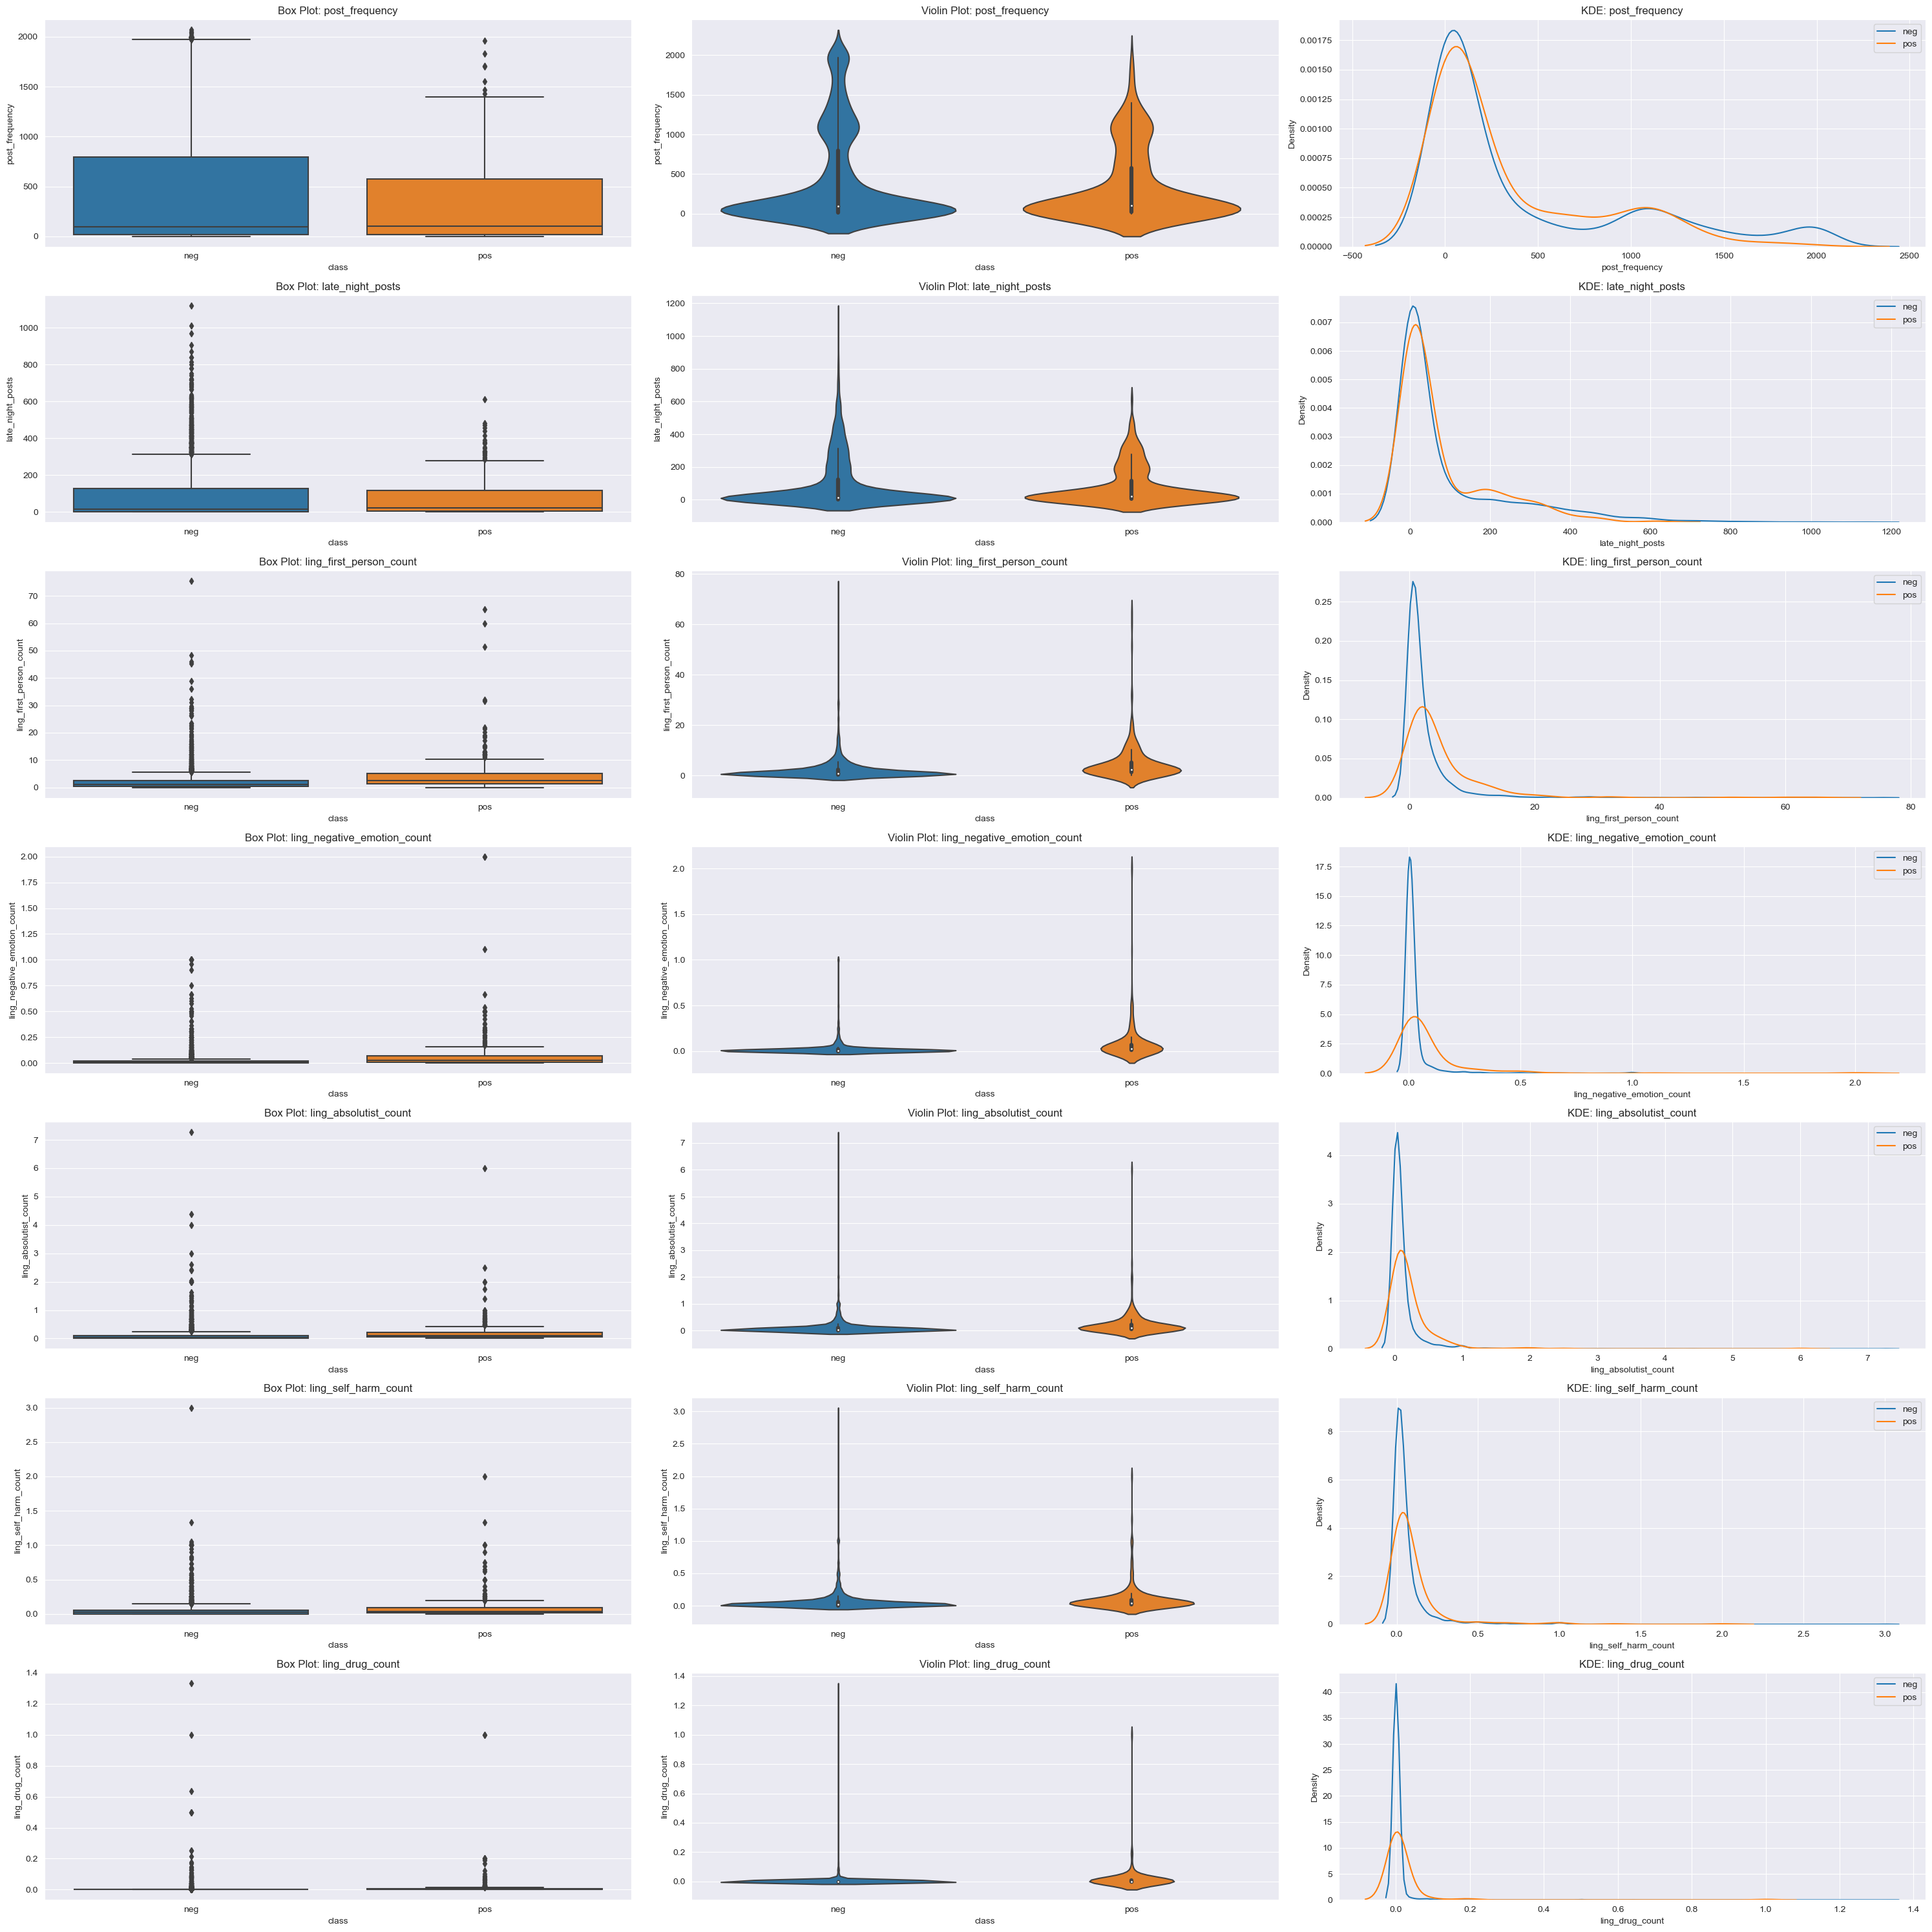

In [165]:
# Create all visualizations with just these function calls
plot_feature_distributions(temporal_df, features)

In [166]:
plot_additional_distributions(temporal_df, features)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 69.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 80.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 45.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 50.5% of the p

KeyboardInterrupt: 

In [161]:
print_statistical_tests(temporal_df, features)


post_frequency:
T-statistic: 2.5895
P-value: 0.0097
Statistically significant difference: Yes

late_night_posts:
T-statistic: 1.6488
P-value: 0.0993
Statistically significant difference: No

ling_first_person_count:
T-statistic: -9.1559
P-value: 0.0000
Statistically significant difference: Yes

ling_negative_emotion_count:
T-statistic: -9.5875
P-value: 0.0000
Statistically significant difference: Yes

ling_absolutist_count:
T-statistic: -5.5614
P-value: 0.0000
Statistically significant difference: Yes

ling_self_harm_count:
T-statistic: -4.3613
P-value: 0.0000
Statistically significant difference: Yes

ling_drug_count:
T-statistic: -3.9030
P-value: 0.0001
Statistically significant difference: Yes
